# Automated Seal Detection and Morphological Classification in Aerial Drone Imagery Using YOLOv8 and CLIP

**Author:** Noor Wahle  
**Affiliation:** Columbia University, MS in Data Science

---

### Project Overview

This project presents an end-to-end computer vision pipeline for the automated detection, counting, and morphological classification of seals using aerial drone imagery from the Wildlife Aerial Image Dataset (WAID). By fine-tuning a YOLOv8 model, we achieve robust detection of seals against complex backgrounds containing diverse animal classes. Beyond simple population counts, we introduce a novel, unsupervised hybrid clustering approach that integrates geometric morphometrics, social proximity features, and CLIP semantic embeddings. This method successfully isolates dominant male "bull" seals from the general population to estimate colony structure. The resulting framework offers a scalable, non-invasive tool for monitoring breeding colony dynamics and reproductive health without human intervention.

---

In [1]:
# ==========================================
# GLOBAL SETUP & IMPORTS
# ==========================================
!pip install ultralytics
!pip install open_clip_torch
!pip install git+https://github.com/openai/CLIP.git

import os
import glob
import random
import yaml
import shutil
import numpy as np
import pandas as pd
import cv2
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image, ImageDraw, ImageStat, ImageOps
from IPython.display import display, Image as IPImage
from tqdm import tqdm
import torch
from ultralytics import YOLO
import open_clip
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Device Config
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Mount Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Helper: Save model to Drive
def backup_model(local_path, drive_path):
    if os.path.exists(local_path):
        shutil.copy(local_path, drive_path)
        print(f"✅ Model backed up to: {drive_path}")
    else:
        print("⚠️ Model file not found for backup.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cyyouvs5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cyyouvs5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=c986e2c84557c3acdd8666e59cadfb2469007fcf8dc3a1a50aa594c6bfaca706
  Stored in directory: /tmp/pip-ephem-wheel-cache-ufdus94r/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.js

## 1. Seal Detection

### Load WAID Dataset Images

In [2]:
# ==========================================
# DATA RESTORATION & CONFIG
# ==========================================
DRIVE_ZIP_PATH = "/content/drive/MyDrive/COMP_VISION/data.zip"
LOCAL_DEST_DIR = "/content/WAID_Local"

# 1. Unzip Data
if not os.path.exists(LOCAL_DEST_DIR):
    print(f"Unzipping {DRIVE_ZIP_PATH}...")
    exit_code = os.system(f'unzip -q -o "{DRIVE_ZIP_PATH}" -d {LOCAL_DEST_DIR}')
    if exit_code == 0:
        print(f"✅ Data extracted to: {LOCAL_DEST_DIR}")
    else:
        print("❌ Unzip failed.")
else:
    print(f"✅ Data exists at {LOCAL_DEST_DIR}")

# 2. Define the Correct Root
# Structure: content/WAID_Local/data/WAID/
REAL_DATASET_ROOT = os.path.join(LOCAL_DEST_DIR, "data", "WAID")

# Safety Check
if not os.path.exists(REAL_DATASET_ROOT):
    print(f"⚠️ Path {REAL_DATASET_ROOT} did not exist. Creating it now...")
    os.makedirs(REAL_DATASET_ROOT, exist_ok=True)
else:
    print(f"📍 Targeting Dataset Root: {REAL_DATASET_ROOT}")

# 3. Create YAML Config
yaml_path = os.path.join(REAL_DATASET_ROOT, "waid_seals.yaml")
yaml_content = f"""
path: {REAL_DATASET_ROOT}
train: images/train
val: images/valid
test: images/test
nc: 6
names: [0, 1, 2, 3, 4, 5]
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content)
print(f"✅ Config created: {yaml_path}")

Unzipping /content/drive/MyDrive/COMP_VISION/data.zip...
✅ Data extracted to: /content/WAID_Local
📍 Targeting Dataset Root: /content/WAID_Local/data/WAID
✅ Config created: /content/WAID_Local/data/WAID/waid_seals.yaml


### Sample Images Visualization

Generating sample grid...


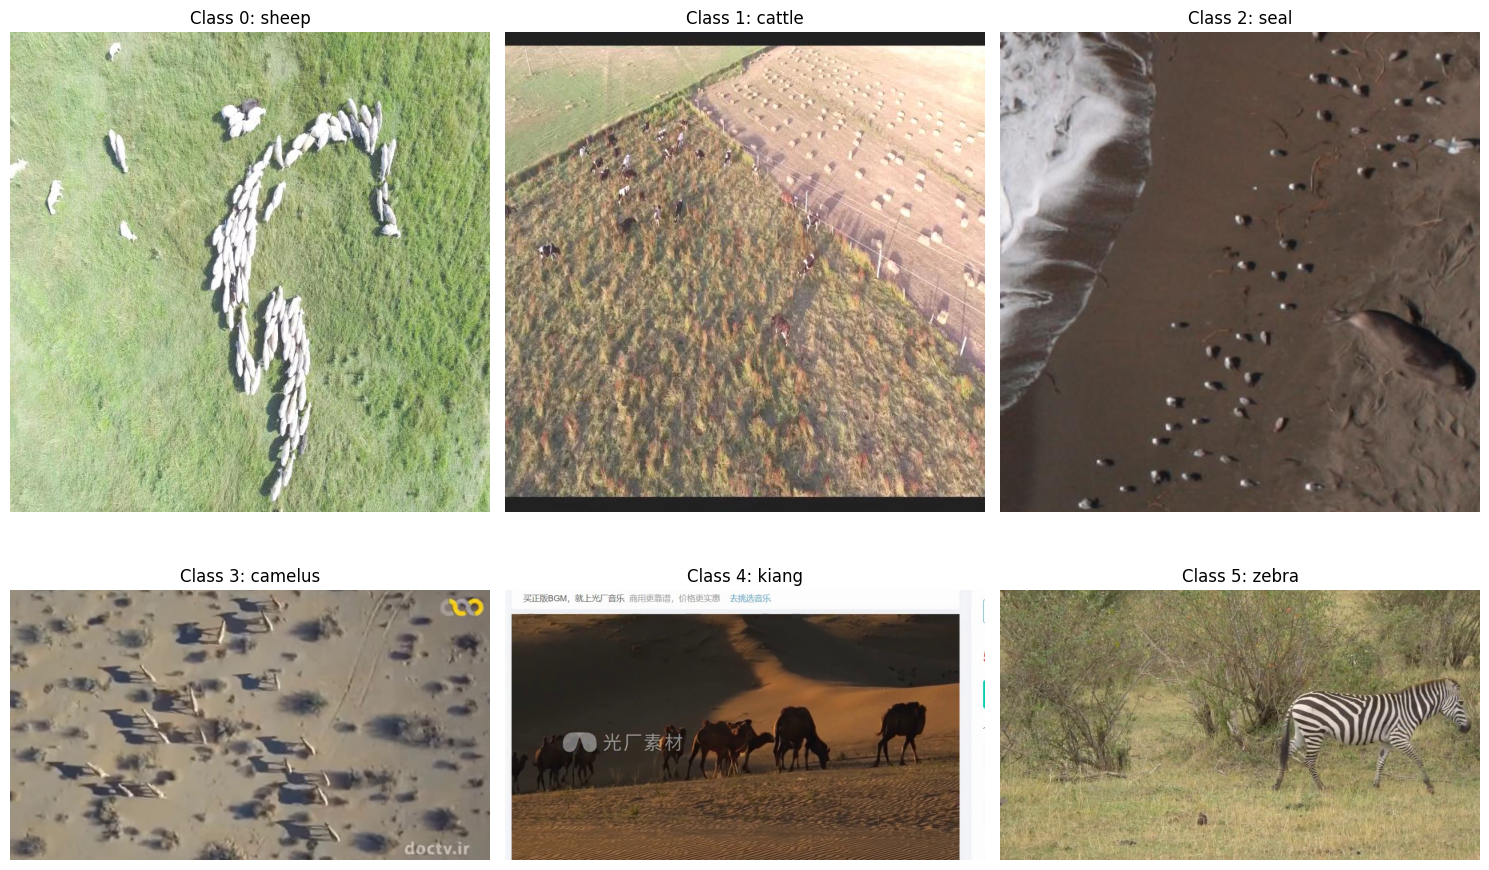

In [3]:
# ==========================================
# VISUALIZE DATASET SAMPLES
# ==========================================
print("Generating sample grid...")
class_names = {0: 'sheep', 1: 'cattle', 2: 'seal', 3: 'camelus', 4: 'kiang', 5: 'zebra'}
img_dir = os.path.join(REAL_DATASET_ROOT, "images", "train")
lbl_dir = os.path.join(REAL_DATASET_ROOT, "labels", "train")

# Auto-detect correct folder name (train vs train_small)
if not os.path.exists(img_dir):
    img_dir = img_dir.replace("train", "train_small")
    lbl_dir = lbl_dir.replace("train", "train_small")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
found_classes = set()
label_files = glob.glob(os.path.join(lbl_dir, "*.txt"))
random.shuffle(label_files)

for lbl_path in label_files:
    if len(found_classes) == 6: break
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if not parts: continue
        cls_id = int(parts[0])

        if cls_id not in found_classes and cls_id in class_names:
            img_path = os.path.join(img_dir, os.path.basename(lbl_path).replace('.txt', '.jpg'))
            if os.path.exists(img_path):
                found_classes.add(cls_id)
                ax = axes[list(class_names.keys()).index(cls_id)]
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(f"Class {cls_id}: {class_names[cls_id]}")
                ax.axis('off')

plt.tight_layout()
plt.show()

### Model Training (YOLOv8)

In [4]:
# ==========================================
# TRAIN MODEL
# ==========================================
model = YOLO("yolov8n.pt")
print("Starting training run...")

results = model.train(
    data=yaml_path,
    imgsz=640,
    batch=16,
    epochs=20,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='runs/YOLOv8_seal_detection',
    name='seal_model_final',
    exist_ok=True,
    plots=True,
)

print("Training complete.")
backup_model("/content/runs/YOLOv8_seal_detection/seal_model_final/weights/best.pt",
             "/content/drive/MyDrive/COMP_VISION/best_seal_model.pt")

Starting training run...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/WAID_Local/data/WAID/waid_seals.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=seal_model_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

#### Detection Evaluation

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.7±6.8 MB/s, size: 92.3 KB)
val: Scanning /content/WAID_Local/data/WAID/labels/test... 1437 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1437/1437 423.1it/s 3.4s
val: New cache created: /content/WAID_Local/data/WAID/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 90/90 5.5it/s 16.4s
                   all       1437      23820      0.914      0.855      0.921      0.563
                     0        424      13323      0.922      0.954      0.969      0.602
                     1        466       6240      0.949      0.923      0.964      0.642
                     2        323       2689      0.935      0.955       0.98      0.692
                     3         82        676      0.871     

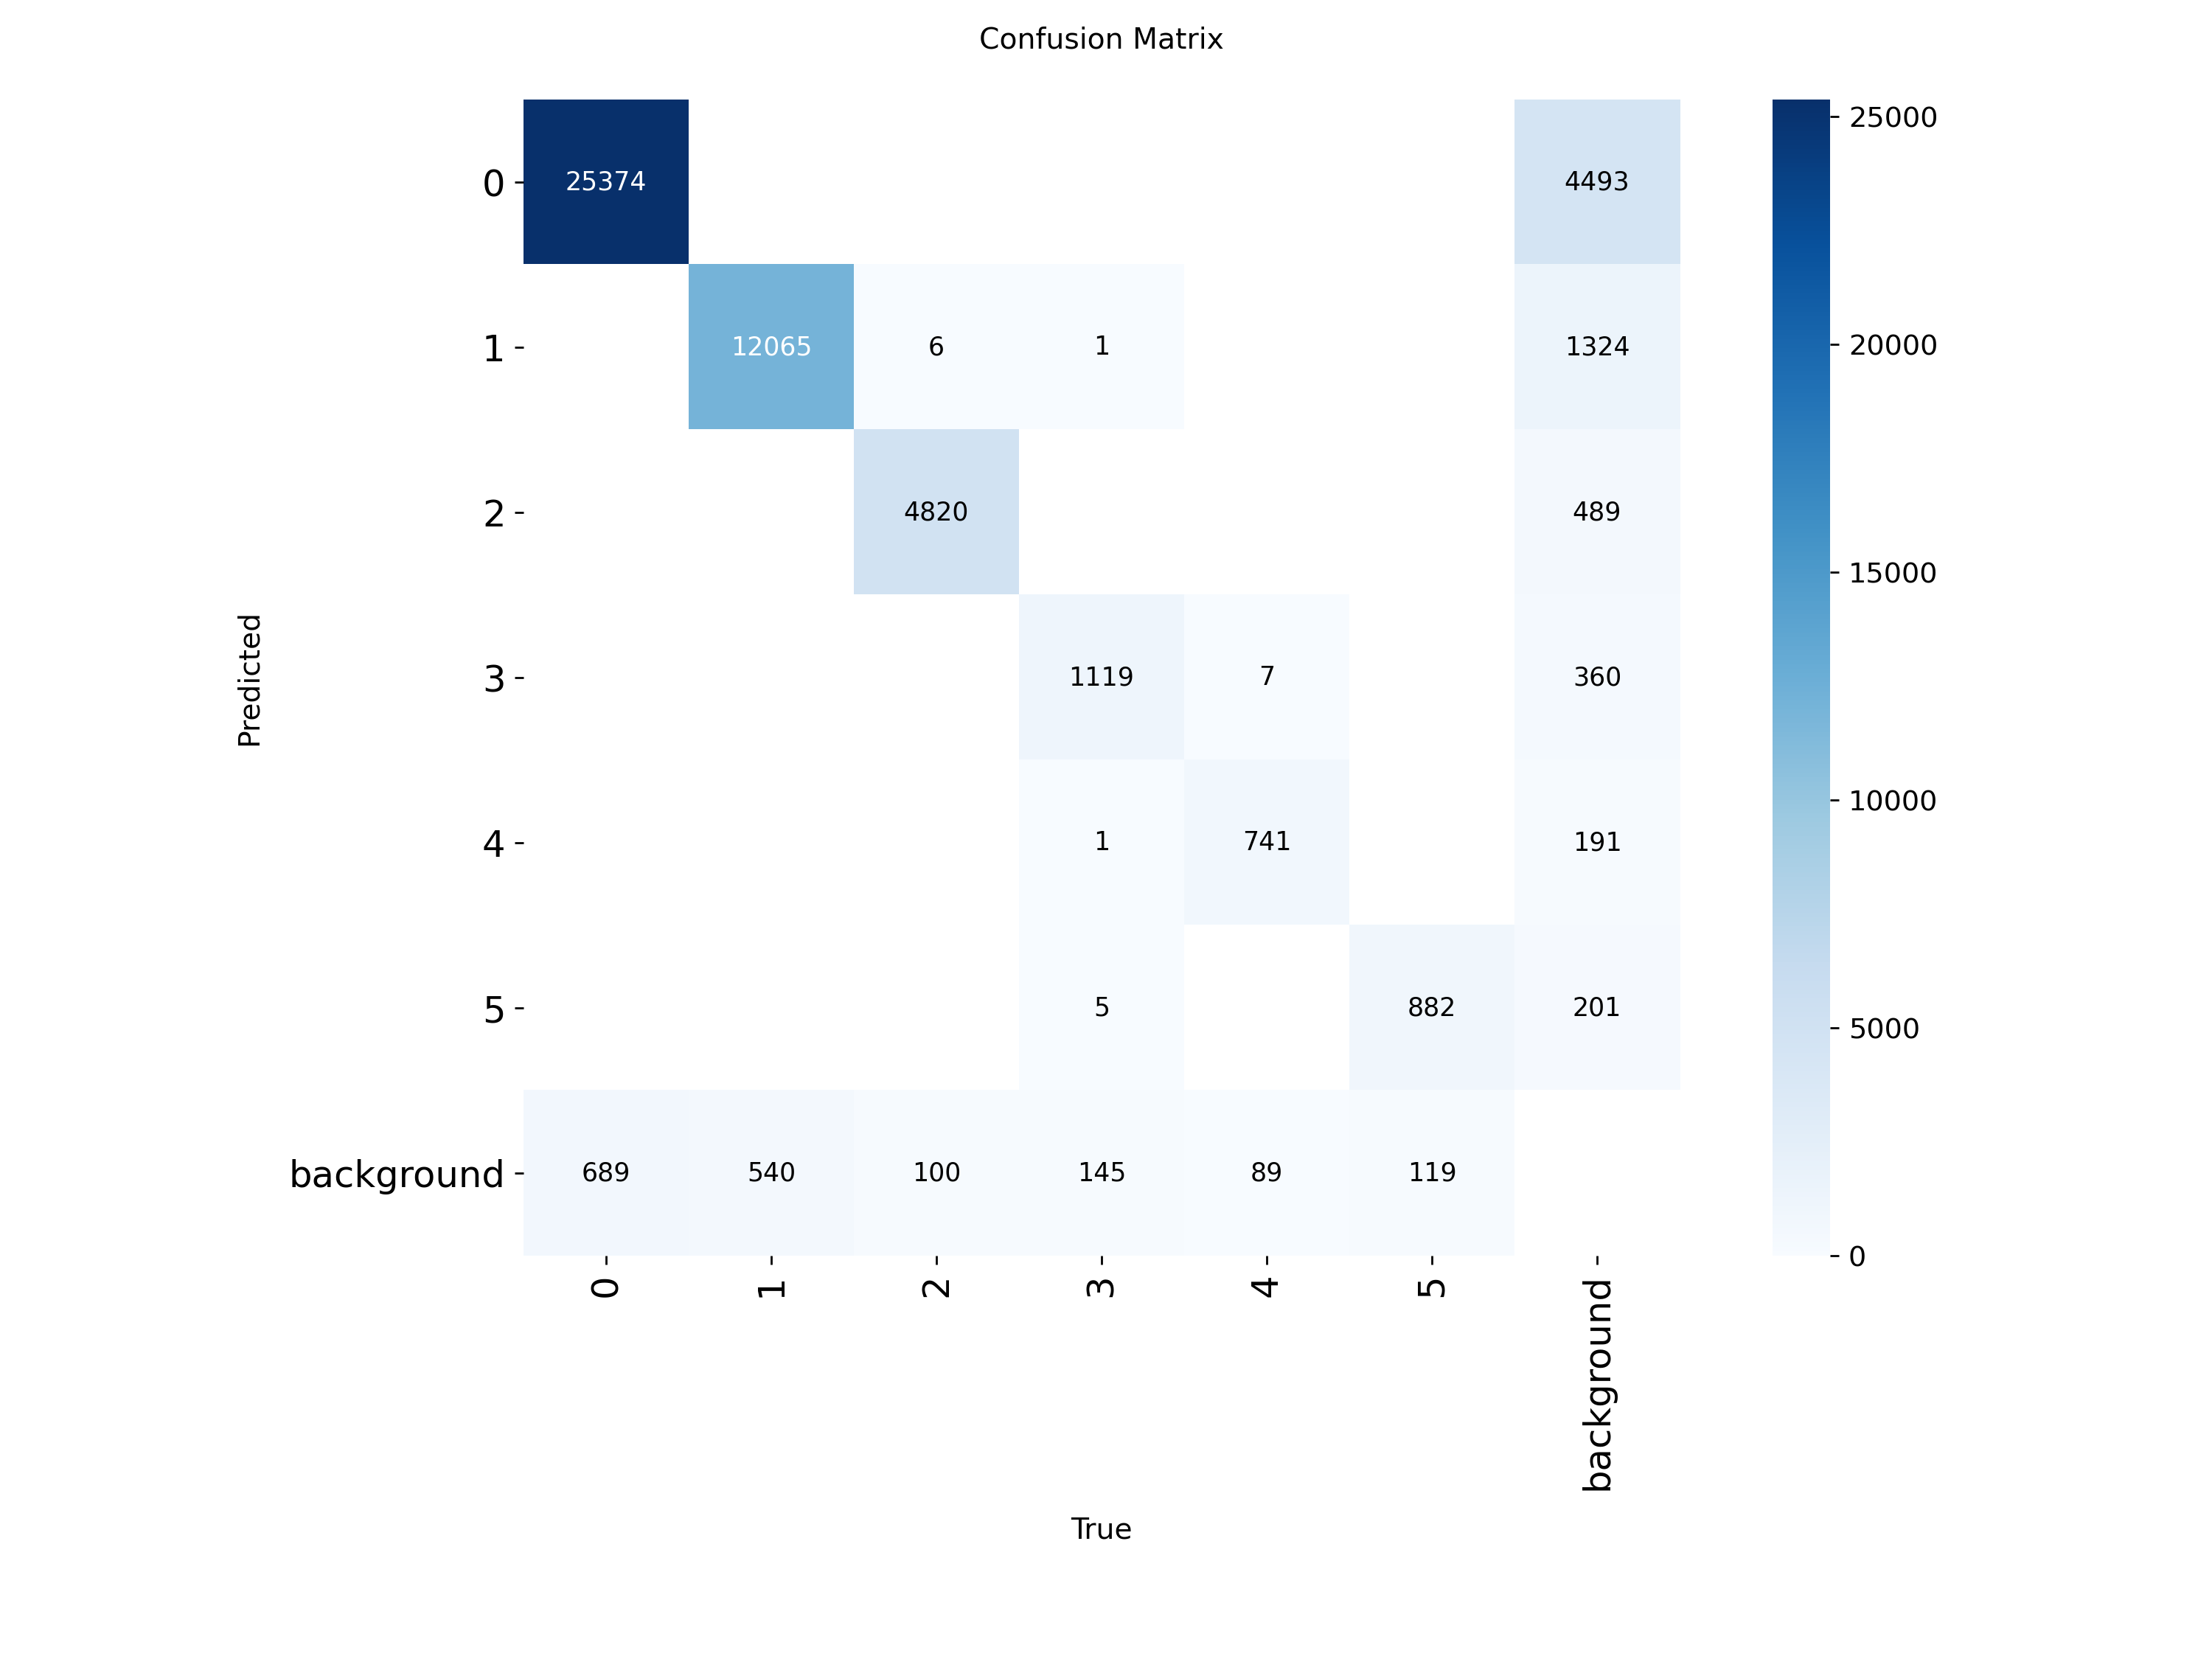

In [5]:
# ==========================================
# EVALUATION
# ==========================================
model = YOLO('/content/runs/YOLOv8_seal_detection/seal_model_final/weights/best.pt')
metrics = model.val(data=yaml_path, split='test')

# Extract Seal Metrics (Class 2)
target_id = 2
try:
    idx = metrics.box.ap_class_index.tolist().index(target_id)
    print("\n" + "="*40)
    print(f"SEAL DETECTION METRICS (Class {target_id})")
    print("="*40)
    print(f"Precision: {metrics.box.p[idx]:.4f}")
    print(f"Recall:    {metrics.box.r[idx]:.4f}")
    print(f"F1-Score:  {metrics.box.f1[idx]:.4f}")
    print(f"mAP@50:    {metrics.box.all_ap[idx, 0]:.4f}")
    print("="*40)
except ValueError:
    print("Seal class not found in test set.")

# Show Confusion Matrix
cm_path = '/content/runs/YOLOv8_seal_detection/seal_model_final/confusion_matrix.png'
if os.path.exists(cm_path):
    display(IPImage(filename=cm_path, width=600))

Found 323 test images containing seals.
Displaying 3 examples of SEAL detections...


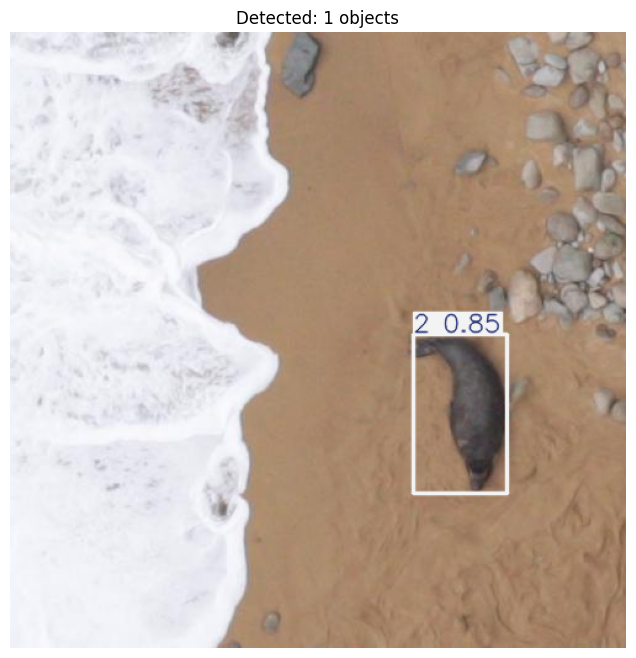

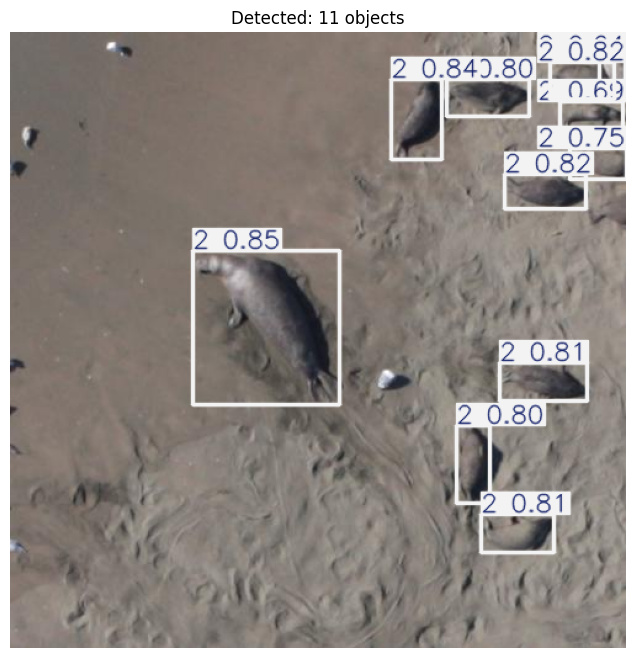

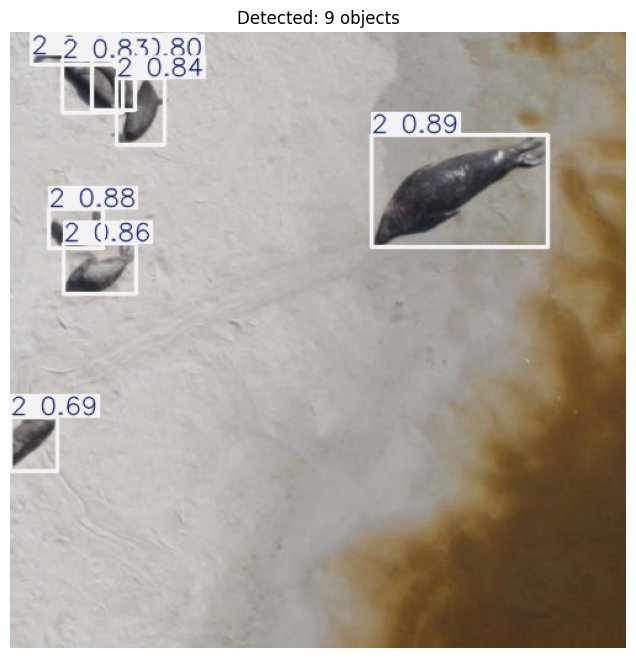

In [10]:
# Find images that actually have seals (using the label files)
# class_id '2' in the text files
label_dir = "/content/WAID_Local/data/WAID/labels/test"
image_dir = "/content/WAID_Local/data/WAID/images/test"

seal_image_paths = []
for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
    with open(label_file, 'r') as f:
        if any(line.strip().startswith("2 ") for line in f):
            # Construct corresponding image path
            basename = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(image_dir, basename)
            if os.path.exists(img_path):
                seal_image_paths.append(img_path)

print(f"Found {len(seal_image_paths)} test images containing seals.")

# Visualize 3 Confirmed Seal Images
print("Displaying 3 examples of SEAL detections...")
selected_images = random.sample(seal_image_paths, 3)

# Run inference
results = model.predict(selected_images, conf=0.6)

for result in results:
    img_array = result.plot()  # Draws boxes
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Detected: {len(result.boxes)} objects")
    plt.show()

## 2. Seal Population Count per Image

### Estimate seal count per image

In [7]:
# ==========================================
# SINGLE-PASS INFERENCE & EXTRACTION
# ==========================================
TEST_IMAGE_DIR = os.path.join(REAL_DATASET_ROOT, "images", "test")
TEST_LABEL_DIR = os.path.join(REAL_DATASET_ROOT, "labels", "test")
CROP_DIR = "/content/waid_seal_crops_final_opt_v2"
if not os.path.exists(CROP_DIR): os.makedirs(CROP_DIR)

# Lists for Counting Task
true_counts = []
pred_counts = []
errors = []

# Lists for Clustering Task
seal_metadata = []

image_paths = sorted(glob.glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
print(f"Running Inference on {len(image_paths)} images...")

# Use tqdm for progress bar
for img_path in tqdm(image_paths):
    # Run Inference
    results = model.predict(img_path, conf=0.6, verbose=False)

    # ---------------------------
    # TASK A: COUNTING LOGIC
    # ---------------------------
    pred_count = (results[0].boxes.cls == 2).sum().item()
    pred_counts.append(pred_count)

    # Ground Truth
    txt_path = os.path.join(TEST_LABEL_DIR, os.path.basename(img_path).replace('.jpg', '.txt'))
    actual_count = 0
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            actual_count = sum(1 for line in f if line.strip().startswith("2 "))
    true_counts.append(actual_count)
    errors.append(abs(pred_count - actual_count))

    # ---------------------------
    # TASK B: FEATURE EXTRACTION LOGIC
    # ---------------------------
    if len(results[0].boxes) > 0:
        original_img = Image.open(img_path).convert("RGB")
        img_gray = np.array(original_img.convert("L"))
        img_w, img_h = original_img.size
        img_diag = np.sqrt(img_w**2 + img_h**2)

        # Collect Centroids for Social Dist
        centroids = []
        valid_boxes = []
        for box in results[0].boxes:
            if int(box.cls[0]) == 2:
                cx, cy = box.xywh[0][:2].tolist()
                centroids.append((cx, cy))
                valid_boxes.append(box)

        dist_matrix = squareform(pdist(centroids)) if len(centroids) > 1 else None

        for i, box in enumerate(valid_boxes):
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            w_box, h_box = x2 - x1, y2 - y1

            # 1. Size
            norm_area = (w_box * h_box) / (img_w * img_h)

            # 2. Social
            if len(centroids) > 1:
                social_dist = dist_matrix[i].min() / img_diag
            else:
                social_dist = 1.0

            # 3. Elongation
            ix1, iy1 = max(0, int(x1)), max(0, int(y1))
            ix2, iy2 = min(img_w, int(x2)), min(img_h, int(y2))
            true_elongation = 1.0

            if ix2 > ix1 and iy2 > iy1:
                crop_cv = img_gray[iy1:iy2, ix1:ix2]
                _, thresh = cv2.threshold(crop_cv, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    c = max(contours, key=cv2.contourArea)
                    if cv2.contourArea(c) > 10:
                        rect = cv2.minAreaRect(c)
                        width, height = rect[1]
                        true_elongation = max(width, height) / (min(width, height) + 1e-6)

            # 4. Texture
            cx1, cy1 = x1 + (w_box * 0.35), y1 + (h_box * 0.35)
            cx2, cy2 = x2 - (w_box * 0.35), y2 - (h_box * 0.35)
            texture_score = 0.0
            if cx2 > cx1 and cy2 > cy1:
                core_crop = original_img.crop((cx1, cy1, cx2, cy2)).convert("L")
                texture_score = ImageStat.Stat(core_crop).stddev[0]

            # Save Crop
            filename = f"seal_{len(seal_metadata)}.jpg"
            save_path = os.path.join(CROP_DIR, filename)
            crop = original_img.crop((x1, y1, x2, y2))
            crop.save(save_path)

            seal_metadata.append({
                'id': len(seal_metadata),
                'crop_path': save_path,
                'original_path': img_path,
                'bbox': (x1, y1, x2, y2),
                'norm_area': norm_area,
                'social_dist': social_dist,
                'true_elongation': true_elongation,
                'texture_score': texture_score
            })

df = pd.DataFrame(seal_metadata)
print(f"✅ Processing Complete. Extracted {len(df)} seals.")

Running Inference on 1437 images...


100%|██████████| 1437/1437 [00:26<00:00, 53.39it/s]


✅ Processing Complete. Extracted 2926 seals.



POPULATION COUNTING METRICS
MAE: 0.25
RMSE: 0.92
Perfect Counts: 1253


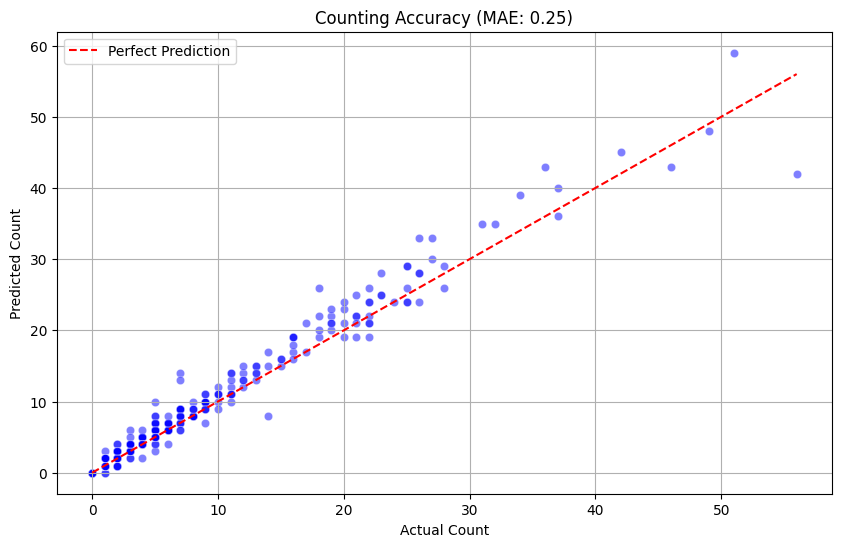

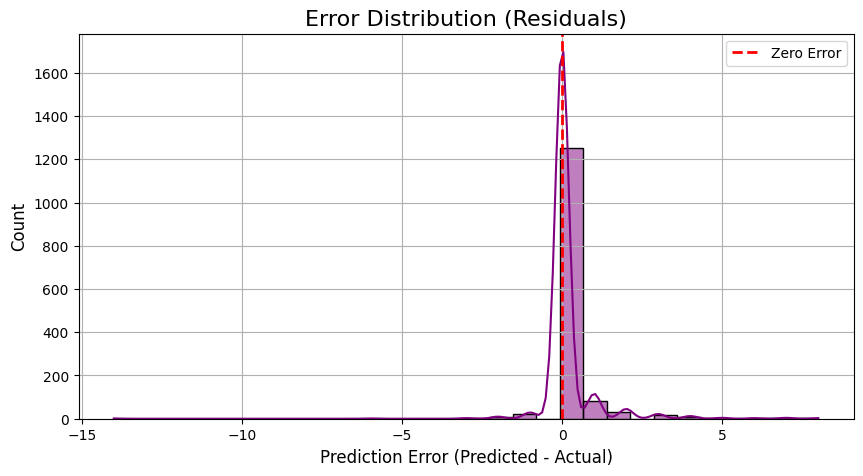

In [13]:
# ==========================================
# COUNTING RESULTS
# ==========================================
true_counts = np.array(true_counts)
pred_counts = np.array(pred_counts)
mae = np.mean(errors)
rmse = np.sqrt(np.mean(np.array(errors)**2))

print("\n" + "="*50)
print(f"POPULATION COUNTING METRICS")
print("="*50)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Perfect Counts: {np.sum(true_counts == pred_counts)}")
print("="*50)

# MAE Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=true_counts, y=pred_counts, alpha=0.5, color='blue')
plt.plot([0, max(true_counts)], [0, max(true_counts)], 'r--', label='Perfect Prediction')
plt.title(f'Counting Accuracy (MAE: {mae:.2f})')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.legend()
plt.grid()
plt.show()

# Error Distribution (Residuals)
plt.figure(figsize=(10, 5))
sns.histplot(pred_counts - true_counts, bins=30, kde=True, color='purple')
plt.axvline(0, color='r', linestyle='--', linewidth=2, label="Zero Error")
plt.title('Error Distribution (Residuals)', fontsize=16)
plt.xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid()
plt.show()

## 3. Morphological Clustering (k=3)

Apply CLIP embeddings to seal crops for unsupervised clustering of potential male bull vs general population seals.

In [20]:
# ==========================================
# CLUSTERING & DEMOGRAPHICS
# ==========================================
print("Generating Embeddings & Running Clustering (K=4)...")

# A. CLIP Embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.to(device)
clip_model.eval()

clip_embeddings = []
paths = df['crop_path'].tolist()

with torch.no_grad():
    for i in tqdm(range(0, len(paths), 32)):
        batch_paths = paths[i : i + 32]
        images = [preprocess(Image.open(p)).unsqueeze(0) for p in batch_paths]
        if not images: continue
        image_input = torch.cat(images).to(device)
        features = clip_model.encode_image(image_input)
        features /= features.norm(dim=-1, keepdim=True)
        clip_embeddings.append(features.cpu().numpy())

X_clip = np.vstack(clip_embeddings)

# B. Weighted Clustering
scaler = StandardScaler()
areas_scaled = scaler.fit_transform(df[['norm_area']])
social_scaled = scaler.fit_transform(df[['social_dist']])
elong_scaled = scaler.fit_transform(df[['true_elongation']])
tex_scaled = scaler.fit_transform(df[['texture_score']])

# --- FINAL WEIGHTS ---
W_SIZE   = 12.0  # Dominant Factor
W_SOCIAL = 2.0   # Isolation Factor
W_TEX    = 1.5   # Secondary Check
W_VIS    = 0.5   # Context
W_ELONG  = 0.1   # Trace Influence

X_final = np.hstack([
    X_clip * W_VIS,
    areas_scaled * W_SIZE,
    social_scaled * W_SOCIAL,
    elong_scaled * W_ELONG,
    tex_scaled * W_TEX
])

# K=4 Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster_label'] = kmeans.fit_predict(X_final)

# C. Results & Label Mapping (Sorted by Size)
cluster_stats = df.groupby('cluster_label')['norm_area'].mean().sort_values()
sorted_ids = cluster_stats.index.tolist()

# Updated Taxonomy
id_map = {
    sorted_ids[0]: "Small (Pups & Females)", # The massive base group
    sorted_ids[1]: "Medium (Adult Females)", # Distinctly larger adults
    sorted_ids[2]: "Large (Sub-Adult Males)",# The bachelor group
    sorted_ids[3]: "Bulls"                   # The massive outliers
}
df['morphotype'] = df['cluster_label'].map(id_map)

# D. Metric Calculation (Cohen's d + ANOVA F-Stat)
bulls = df[df['morphotype'] == "Bulls"]
others = df[df['morphotype'] != "Bulls"]

print("\n" + "="*80)
print(f"CLUSTERING METRICS (FINAL)")
print("="*80)
print(f"Silhouette Score: {silhouette_score(X_final, df['cluster_label']):.4f}")
print("\nCluster Counts:")
print(df['morphotype'].value_counts())

print("\n--- Feature Separation (Bulls vs. Everyone Else) ---")
print(f"{'FEATURE':<20} | {'BULL MEAN':<10} | {'OTHERS MEAN':<10} | {'COHEN\'S D':<12} | {'ANOVA F-STAT':<12}")
print("-" * 80)

from scipy.stats import f_oneway

features_to_check = {
    "Size (Norm Area)": 'norm_area',
    "Social Dist": 'social_dist',
    "Elongation": 'true_elongation',
    "Texture": 'texture_score'
}

for feat_name, col_name in features_to_check.items():
    if len(bulls) > 1 and len(others) > 1:
        mu1, mu2 = bulls[col_name].mean(), others[col_name].mean()
        s1, s2 = bulls[col_name].std(), others[col_name].std()
        pooled_std = np.sqrt((s1**2 + s2**2) / 2)
        cohens_d = abs(mu1 - mu2) / (pooled_std + 1e-6)
        f_stat, p_val = f_oneway(bulls[col_name], others[col_name])
        star = "⭐" if cohens_d > 0.8 else ""
        print(f"{feat_name:<20} | {mu1:.4f}     | {mu2:.4f}      | {cohens_d:.4f}       | {f_stat:.1f} {star}")

print("="*80)

Generating Embeddings & Running Clustering (K=4)...


100%|██████████| 92/92 [00:14<00:00,  6.53it/s]



📊 CLUSTERING METRICS (FINAL)
Silhouette Score: 0.6239

Cluster Counts:
morphotype
Small (Pups & Females)     1986
Medium (Adult Females)      579
Large (Sub-Adult Males)     233
Bulls                       128
Name: count, dtype: int64

--- Feature Separation (Bulls vs. Everyone Else) ---
FEATURE              | BULL MEAN  | OTHERS MEAN | COHEN'S D    | ANOVA F-STAT
--------------------------------------------------------------------------------
Size (Norm Area)     | 0.0514     | 0.0120      | 4.3947       | 2719.3 ⭐
Social Dist          | 0.1094     | 0.0147      | 0.3992       | 60.7 
Elongation           | 2.5846     | 2.4622      | 0.1246       | 1.8 
Texture              | 28.4554     | 21.8904      | 0.5752       | 44.9 



Generating Feature Distributions...


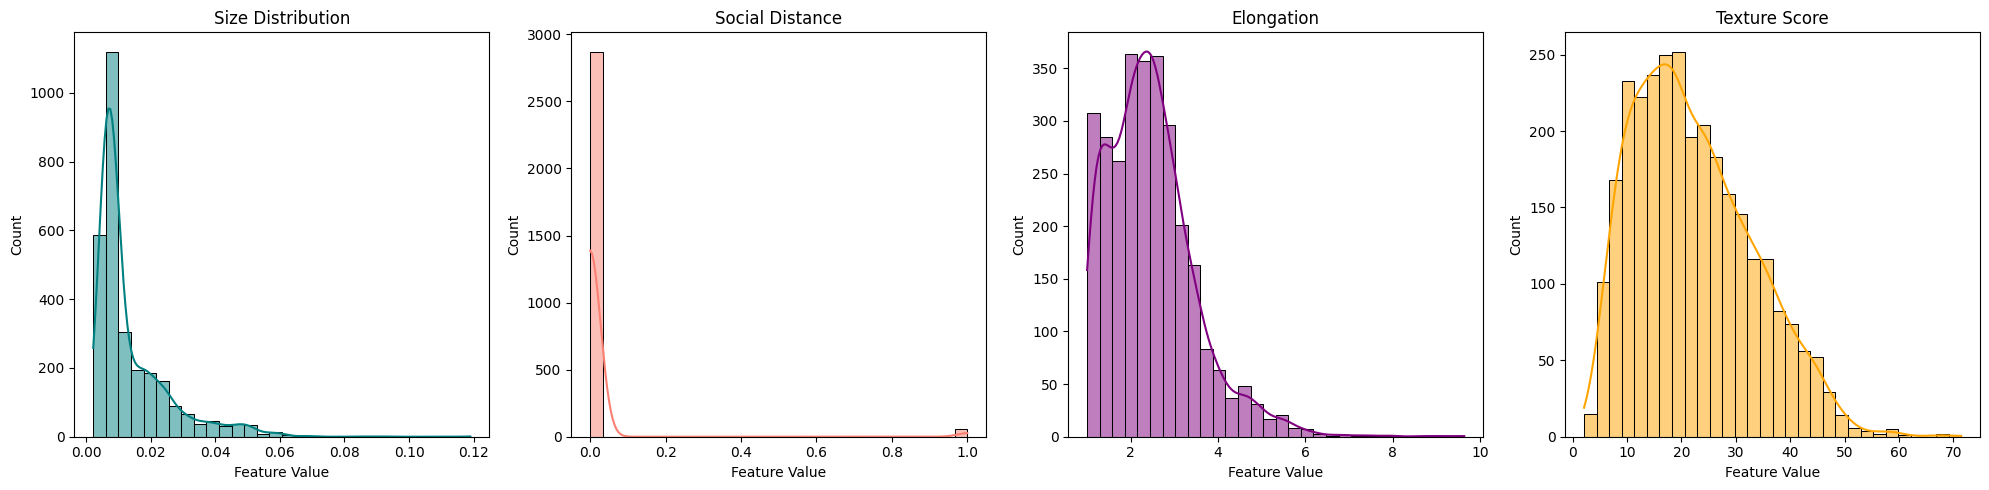


Generating Cluster Separation Boxplots...


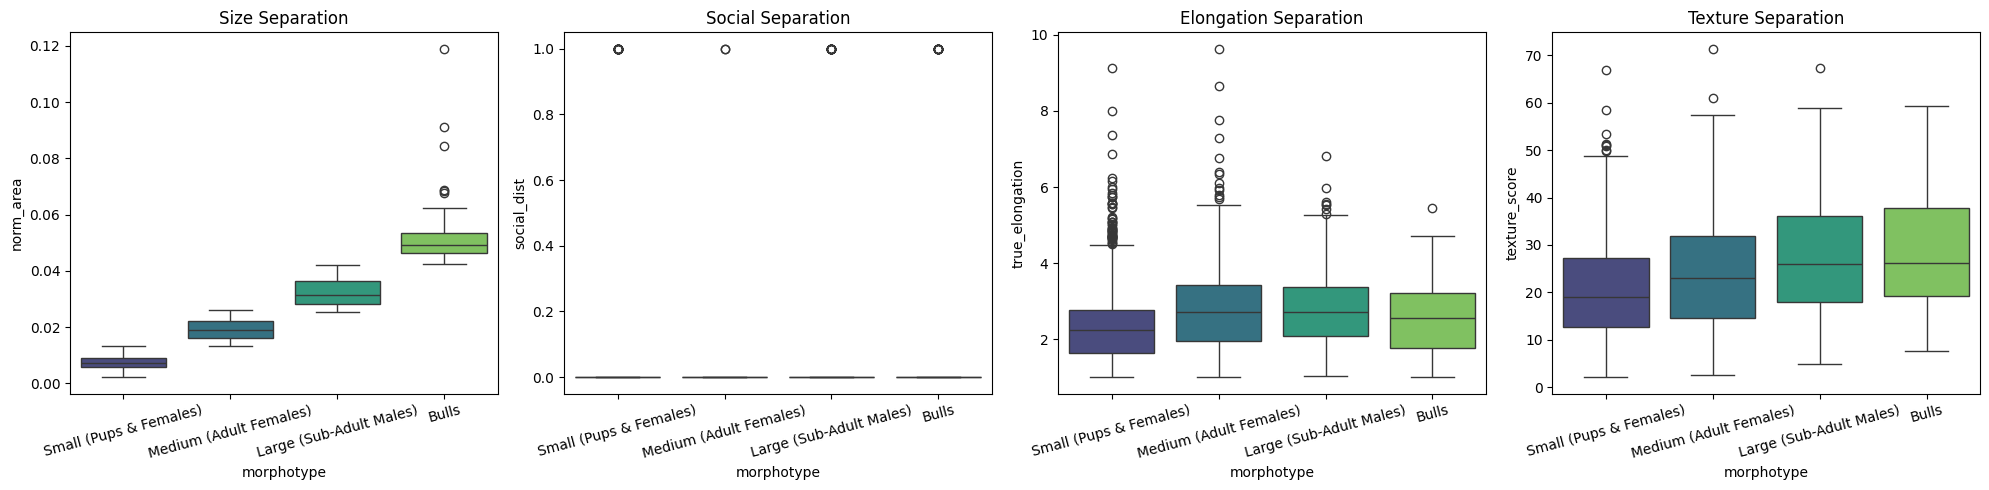


Visualizing Results...


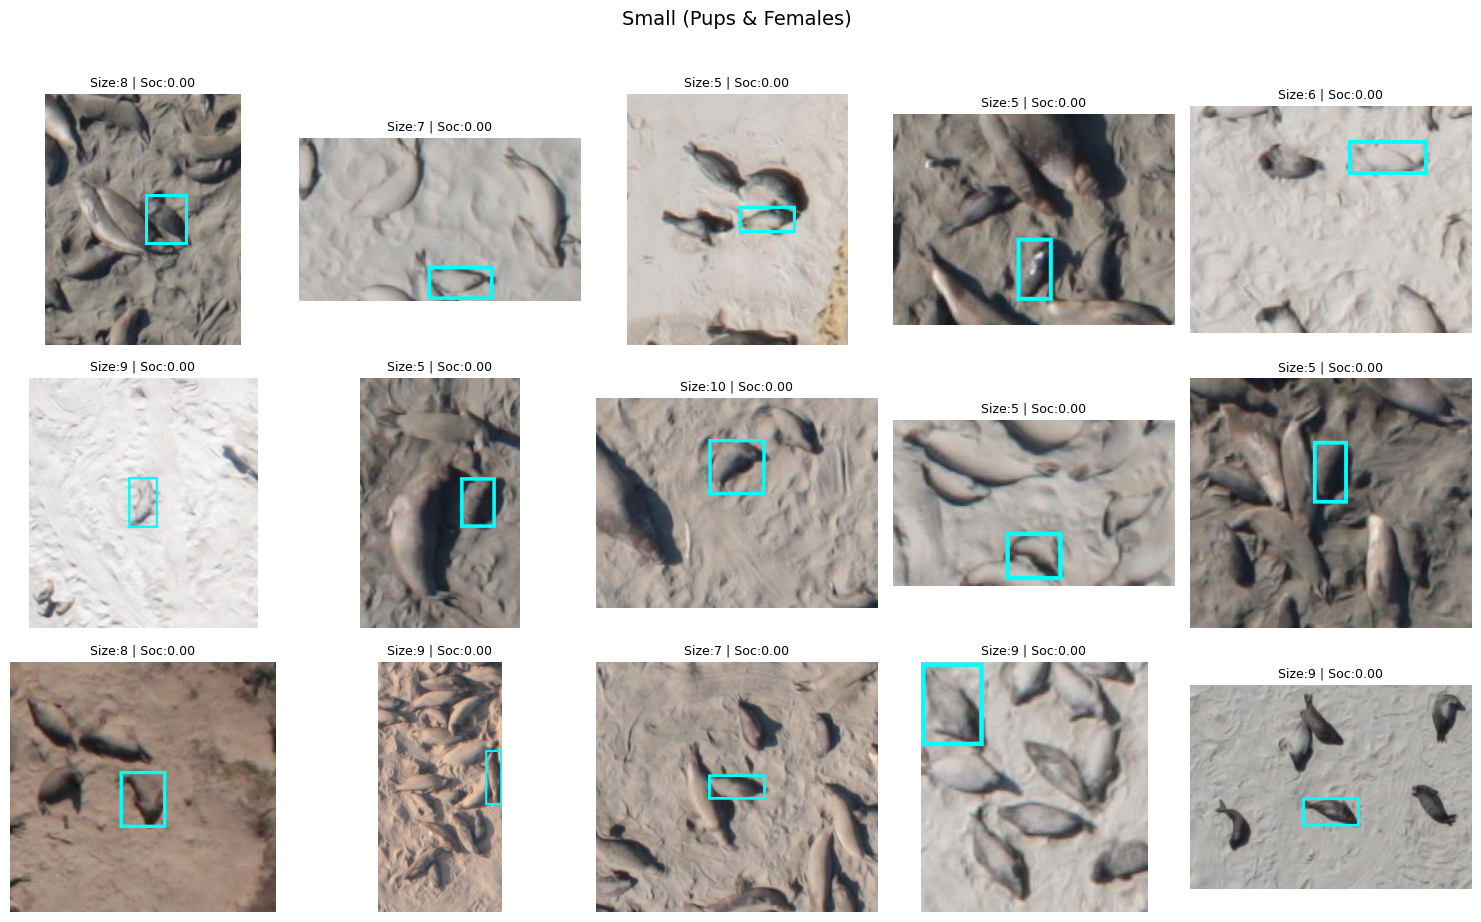

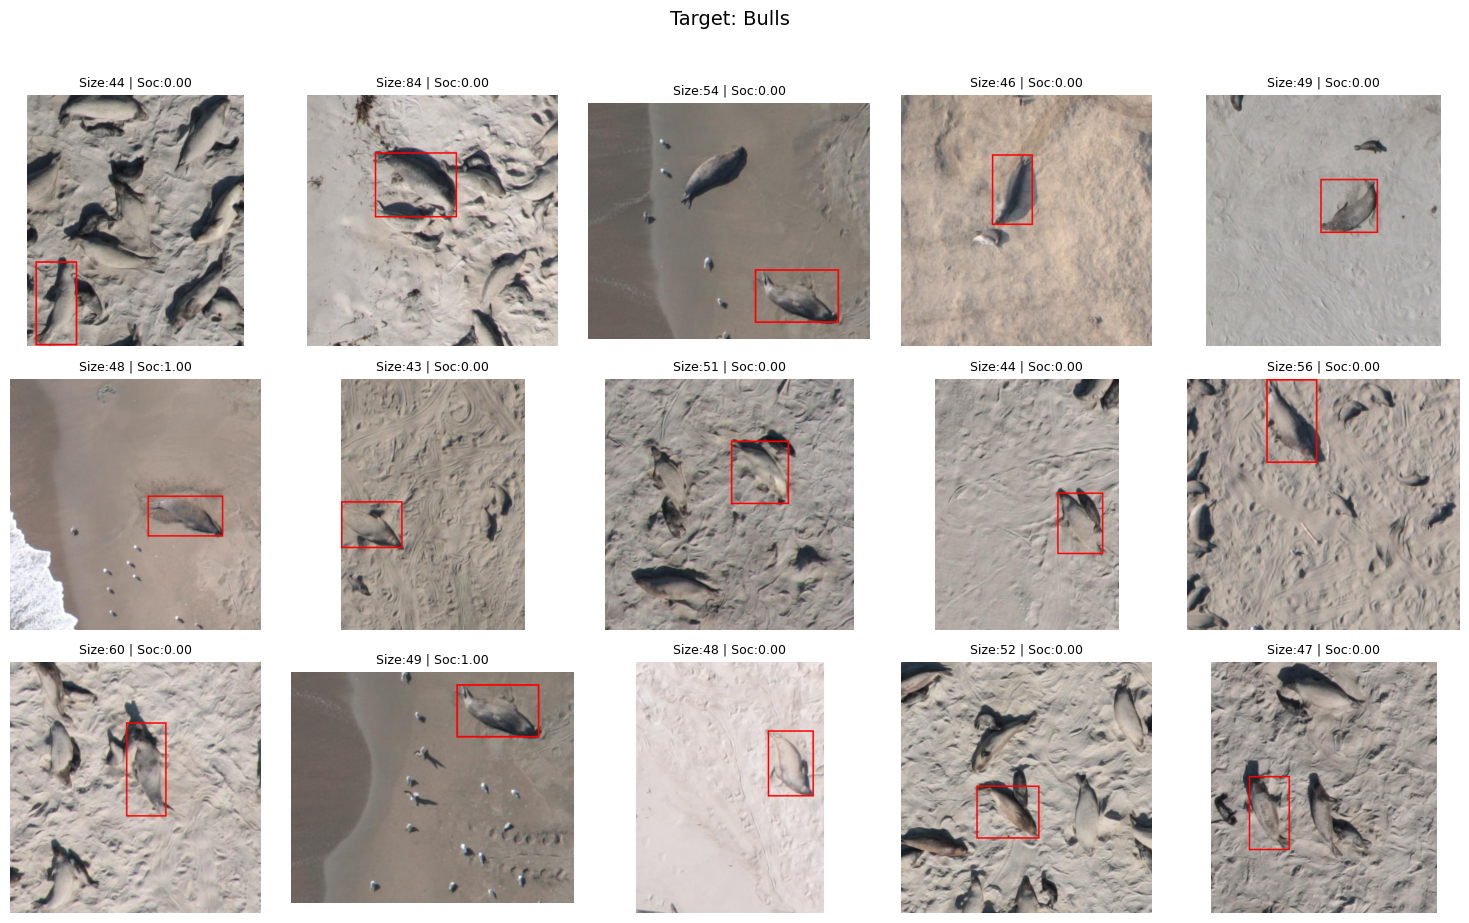

In [24]:
# E. Visualizations

# 1. Feature Distributions
print("\nGenerating Feature Distributions...")
plt.figure(figsize=(20, 5))
cols = ['norm_area', 'social_dist', 'true_elongation', 'texture_score']
titles = ['Size Distribution', 'Social Distance', 'Elongation', 'Texture Score']
colors = ['teal', 'salmon', 'purple', 'orange']

for i in range(4):
    plt.subplot(1, 4, i+1)
    sns.histplot(df[cols[i]], bins=30, kde=True, color=colors[i])
    plt.title(titles[i])
    plt.xlabel("Feature Value")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Cluster Separation (Boxplots)
print("\nGenerating Cluster Separation Boxplots...")
plt.figure(figsize=(20, 5))
titles_box = ['Size Separation', 'Social Separation', 'Elongation Separation', 'Texture Separation']

for i in range(4):
    plt.subplot(1, 4, i+1)
    sns.boxplot(data=df, x='morphotype', y=cols[i], palette='viridis', order=id_map.values())
    plt.title(titles_box[i])
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 3. Sample Images
def plot_cluster_grid(target_labels, caption, box_color):
    indices = df[df['morphotype'].isin(target_labels)].index.tolist()
    if not indices: return

    # Pick 15 random samples
    sample_idxs = random.sample(indices, min(15, len(indices)))

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    fig.suptitle(caption, fontsize=14, y=1.02)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(sample_idxs):
            idx = sample_idxs[i]
            meta = seal_metadata[idx]

            with Image.open(meta['original_path']) as orig_img:
                orig_img = orig_img.convert("RGB")
                w, h = orig_img.size
                x1, y1, x2, y2 = meta['bbox']

                padding = max(x2-x1, y2-y1) * 2.0
                cx1, cy1 = max(0, x1-padding), max(0, y1-padding)
                cx2, cy2 = min(w, x2+padding), min(h, y2+padding)
                context_crop = orig_img.crop((cx1, cy1, cx2, cy2))

                draw = ImageDraw.Draw(context_crop)
                draw.rectangle([x1-cx1, y1-cy1, x2-cx1, y2-cy1], outline=box_color, width=3)

                ax.imshow(context_crop)
                ax.axis('off')
                ax.set_title(f"Size:{meta['norm_area']*1000:.0f} | Soc:{meta['social_dist']:.2f}", fontsize=9)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing Results...")
plot_cluster_grid(["Small (Pups & Females)"],
                  'Small (Pups & Females)',
                  "cyan")

plot_cluster_grid(["Bulls"],
                  'Target: Bulls',
                  "red")